# Prepare data

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os, sys

def find_src_dir(start_path=None):
    """
    从 start_path 开始往上依次查找，直到根目录都没找到就报错。
    找到某层目录下有个 src 子文件夹就返回它的绝对路径。
    """
    if start_path is None:
        start_path = os.getcwd()
    path = start_path
    while True:
        candidate = os.path.join(path, "src")
        if os.path.isdir(candidate):
            return candidate
        parent = os.path.dirname(path)
        if parent == path:  # 已经到根目录了
            break
        path = parent
    raise FileNotFoundError(f"找不到 src 目录，已搜索到 {start_path} 的所有父级路径")

# 找到 src 并插入到 sys.path
try:
    SRC_PATH = find_src_dir()
    sys.path.insert(0, SRC_PATH)
    print("✅ 已将 src 添加到模块搜索路径：", SRC_PATH)
except FileNotFoundError as e:
    print("❌", e)

# 现在再试 import
from preprocess import *
#from tf_models import *
from torch_models import *

print("✅ import 成功！")

✅ 已将 src 添加到模块搜索路径： /Users/liujinxian/Desktop/NewNeworkForecast/ICC26/src
✅ import 成功！


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker
base_dir = ".."

In [19]:
#file_name = f"{base_dir}/Processed_Dataset/CERNET_15min.csv"  # the input filename
file_name = f"{base_dir}/data/processed/CERNET.csv"  # the input filename
#file_name = f"{base_dir}/Processed_Dataset/Abilene_15min.csv"  # the input filename

In [20]:
df = pd.read_csv(file_name)
df = df.set_index('date')
df = df.dropna()
df = df.loc['2004-05-01':]
print(np.isnan(df).any(), np.isnan(df).any())

data    False
dtype: bool data    False
dtype: bool


In [21]:
df

,data
date,
2013-02-19 22:00:00,14961.012148
2013-02-19 23:00:00,12031.262185
2013-02-20 00:00:00,6400.142220
2013-02-20 01:00:00,3261.291051
2013-02-20 02:00:00,1978.597413
...,...
2013-03-26 11:00:00,31927.478640
2013-03-26 12:00:00,33363.036962
2013-03-26 13:00:00,34203.060161


# Temp Torch

MAE:  1197.4035
RMSE: 1767.2327
MAPE: 6.91%


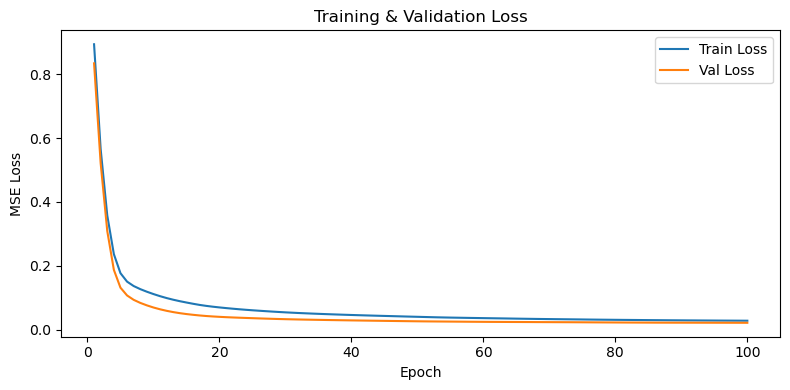

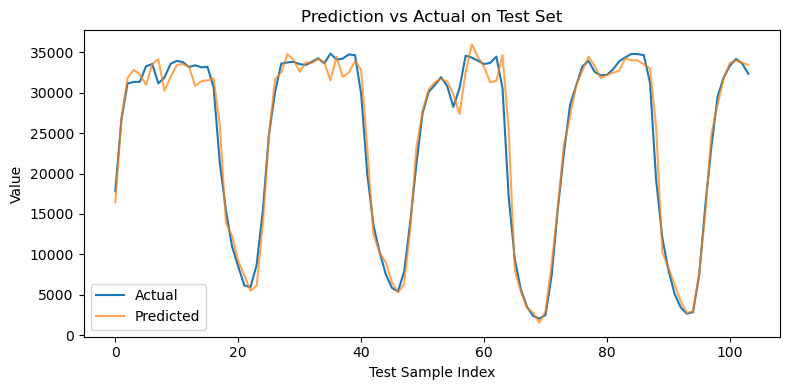

In [22]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 假設你的 df 已經載入且長這樣：
#                     value
# 2013-02-19 22:00:00 14961.012148
# 2013-02-19 23:00:00 12031.262185
# 2013-02-20 00:00:00  6400.142220
# ...                     ...
# 2013-03-26 15:00:00 32353.788178

# 1. 取出 numpy 陣列
values_raw = df['data'].values.astype(float)

# 2. 計算序列長度、切分比例
lag     = 8
N       = len(values_raw) - lag
n_train = int(N * 0.75)
n_val   = int(N * 0.125)
n_test  = N - n_train - n_val

# 3. 只用訓練集對 scaler 做 fit
#    訓練階段會用到 values_raw[0 : n_train + lag]
scaler = StandardScaler()
train_for_scaler = values_raw[: n_train + lag].reshape(-1, 1)
scaler.fit(train_for_scaler)

# 4. 對整條序列做 transform
values = scaler.transform(values_raw.reshape(-1,1)).flatten()

# 5. 建 lag 序列 (全部用 scaled 後的 values)
X, y = [], []
for i in range(len(values) - lag):
    X.append(values[i:i+lag])
    y.append(values[i+lag])
X = torch.tensor(X, dtype=torch.float32)         # shape=(N,8)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape=(N,1)

# 6. 切分 train / val / test
X_train, y_train = X[:n_train],                          y[:n_train]
X_val,   y_val   = X[n_train:n_train + n_val],           y[n_train:n_train + n_val]
X_test,  y_test  = X[n_train + n_val:],                  y[n_train + n_val:]

# 7. Dataset & DataLoader
class TS_Dataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_loader = DataLoader(TS_Dataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(TS_Dataset(X_val,   y_val),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TS_Dataset(X_test,  y_test),  batch_size=batch_size, shuffle=False)

# 8. 定義簡單全連接模型
class FeedforwardNN(nn.Module):
    def __init__(self, input_size=lag, hidden_size=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.net(x)

model     = FeedforwardNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 9. 訓練 & 驗證，並記錄 loss
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(1, num_epochs+1):
    # 訓練
    model.train()
    batch_losses = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))

    # 驗證
    model.eval()
    batch_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            batch_losses.append(criterion(model(xb), yb).item())
    val_losses.append(np.mean(batch_losses))

# 10. 在測試集上做預測（scaled 空間）
model.eval()
preds_scaled, actuals_scaled = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb)
        preds_scaled.extend(out.squeeze().tolist())
        actuals_scaled.extend(yb.squeeze().tolist())

preds_scaled   = np.array(preds_scaled).reshape(-1,1)
actuals_scaled = np.array(actuals_scaled).reshape(-1,1)

# 11. 反標準化回原始尺度
preds   = scaler.inverse_transform(preds_scaled).flatten()
actuals = scaler.inverse_transform(actuals_scaled).flatten()

# 12. 計算 MAE, RMSE, MAPE (原始尺度)
errors = preds - actuals
mae  = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))
mape = np.mean(np.abs(errors / actuals)) * 100

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# 13. 繪製訓練 & 驗證 Loss 曲線
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 14. 繪製預測 vs 實際
plt.figure(figsize=(8,4))
plt.plot(actuals, label='Actual')
plt.plot(preds,   label='Predicted', alpha=0.7)
plt.xlabel('Test Sample Index')
plt.ylabel('Value')
plt.title('Prediction vs Actual on Test Set')
plt.legend()
plt.tight_layout()
plt.show()


/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


MAE:  1008.0920
RMSE: 1510.6887
MAPE: 6.86%


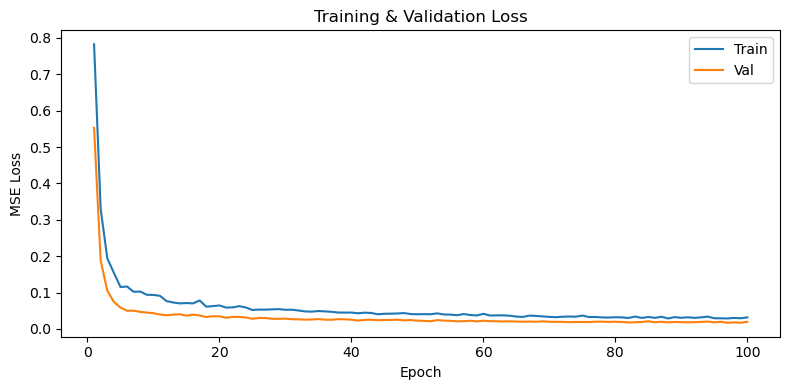

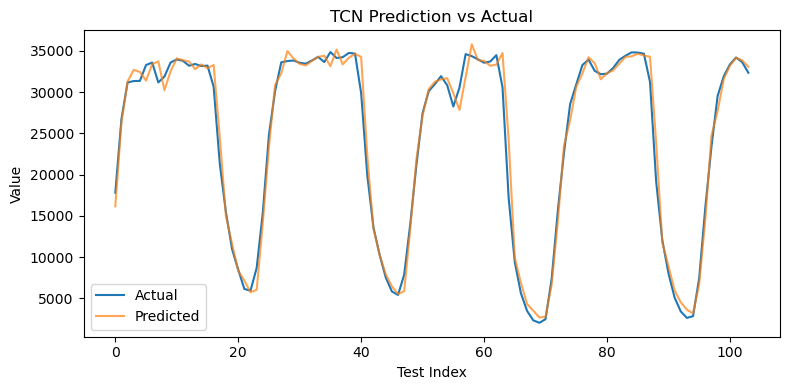

In [24]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import weight_norm

# 假設 df 已經載入
values_raw = df['data'].values.astype(float)

# 超參數
lag       = 8
batch_size= 32
lr        = 1e-3
num_epochs= 100

# 切分比例計算
N        = len(values_raw) - lag
n_train  = int(N * 0.75)
n_val    = int(N * 0.125)
n_test   = N - n_train - n_val

# 標準化 (只對訓練集做 fit)
scaler = StandardScaler()
scaler.fit(values_raw[:n_train+lag].reshape(-1,1))
values = scaler.transform(values_raw.reshape(-1,1)).flatten()

# 建 X, y
X, y = [], []
for i in range(len(values)-lag):
    X.append(values[i:i+lag])
    y.append(values[i+lag])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# 切分
X_train, y_train = X[:n_train],                  y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val],     y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:],            y[n_train+n_val:]

# Dataset & DataLoader
class TS_Dataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TS_Dataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(TS_Dataset(X_val,   y_val),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TS_Dataset(X_test,  y_test),  batch_size=batch_size, shuffle=False)

# ------------------------------------------------
# 8. 定義 TCN
# ------------------------------------------------
class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv1 = weight_norm(nn.Conv1d(in_ch, out_ch, kernel_size,
                                           padding=padding, dilation=dilation))
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv1d(out_ch, out_ch, kernel_size,
                                           padding=padding, dilation=dilation))
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)
        self.downsample = (nn.Conv1d(in_ch, out_ch, 1)
                           if in_ch != out_ch else None)
        self.init_weights()

    def init_weights(self):
        for m in [self.conv1, self.conv2]:
            nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        out = self.conv1(x)
        out = out[:, :, : -self.conv1.padding[0]]  # 修正多餘 padding
        out = self.relu1(out)
        out = self.drop1(out)

        out = self.conv2(out)
        out = out[:, :, : -self.conv2.padding[0]]
        out = self.relu2(out)
        out = self.drop2(out)

        res = x if self.downsample is None else self.downsample(x)
        return torch.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            in_ch = num_inputs if i == 0 else num_channels[i-1]
            layers.append(TemporalBlock(in_ch, out_ch,
                                        kernel_size=kernel_size,
                                        dilation=2**i,
                                        dropout=dropout))
        self.network = nn.Sequential(*layers)
        self.linear  = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        # x: (batch, lag)
        x = x.unsqueeze(1)            # -> (batch, 1, lag)
        y = self.network(x)           # -> (batch, C_last, lag)
        out = y[:, :, -1]             # 取最後一個時刻 -> (batch, C_last)
        return self.linear(out)       # -> (batch, 1)

# 建模型
model     = TCN(num_inputs=1, num_channels=[25,25], kernel_size=3, dropout=0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# ------------------------------------------------
# 9. 訓練 & 驗證，並記錄 loss
# ------------------------------------------------
train_losses, val_losses = [], []
for epoch in range(1, num_epochs+1):
    model.train()
    batch_l = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        batch_l.append(loss.item())
    train_losses.append(np.mean(batch_l))

    model.eval()
    batch_l = []
    with torch.no_grad():
        for xb, yb in val_loader:
            batch_l.append(criterion(model(xb), yb).item())
    val_losses.append(np.mean(batch_l))

# ------------------------------------------------
# 10. 測試, 指標 & 繪圖
# ------------------------------------------------
model.eval()
preds_s, acts_s = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb)
        preds_s.extend(out.squeeze().tolist())
        acts_s.extend(yb.squeeze().tolist())

preds_s = np.array(preds_s).reshape(-1,1)
acts_s  = np.array(acts_s).reshape(-1,1)

# 反標準化
preds   = scaler.inverse_transform(preds_s).flatten()
actuals = scaler.inverse_transform(acts_s).flatten()

# 計算指標
errors = preds - actuals
mae   = np.mean(np.abs(errors))
rmse  = np.sqrt(np.mean(errors**2))
mape  = np.mean(np.abs(errors/actuals)) * 100
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# Loss 曲線
plt.figure(figsize=(8,4))
plt.plot(range(1,num_epochs+1), train_losses, label='Train')
plt.plot(range(1,num_epochs+1), val_losses,   label='Val')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend(); plt.tight_layout(); plt.show()

# 預測 vs 實際
plt.figure(figsize=(8,4))
plt.plot(actuals, label='Actual')
plt.plot(preds,   label='Predicted', alpha=0.7)
plt.xlabel('Test Index'); plt.ylabel('Value')
plt.title('TCN Prediction vs Actual')
plt.legend(); plt.tight_layout(); plt.show()


# ML

## Create Dataset

In [106]:
# 假設 df_encoded 是你的 DataFrame，且已經按時間順序排序
lag = 8
minutes = 60
n_steps = int ( 8 * (60 / minutes) )  # 例如，使用t以及前面5步作為特徵

X, y = create_dataset(df.to_numpy(), n_steps)

print(y)
print(X.shape)
print(y.shape)

[ 1696.29036506  1701.35026527  3187.69679721  6980.59283688
 11608.88335338 13888.18347825 15770.93130797 15270.28284536
 15830.97403289 15682.00594193 16414.32681292 17132.15929772
 19388.41612949 20765.19551918 21151.98847594 22230.37395428
 20861.89576708 15996.13764464 10159.700267    5354.06202381
  3485.48403259  3166.07070601  2966.2229988   2487.99487199
  1754.79594301  1934.74014814  4395.3574391  10893.75173942
 15516.39023712 17103.27028352 18546.7858948  18925.80903864
 18753.79373323 19421.67016133 20149.86910799 20608.71545857
 21284.34528229 24066.59766106 24917.9647746  25650.51683797
 24291.59776501 20235.76053202 12046.66125366  7964.45552413
  5158.11988894  3358.94922453  2551.02284792  2250.81872192
  1981.26133701  2479.98929761  6347.18664656 13983.64041291
 18986.06379769 21370.99720675 21591.18817543 22684.89640456
 22545.27448383 23228.29760918 23924.96728772 21977.61276197
 22462.41559633 26104.56244954 27921.41990552 28382.38205146
 28407.65004148 26655.41

## Splitting

In [107]:
# Total number of samples
total_samples = X.shape[0]

# Calculate the number of samples for each set
num_train = int(total_samples * 0.75)
num_validation = int(total_samples * 0.125)

# Calculate the indices for splitting
index_train = num_train
index_validation = index_train + num_validation

# Split the data based on calculated indices
X_train, X_validation, X_test = X[:index_train], X[index_train:index_validation], X[index_validation:]
y_train, y_validation, y_test = y[:index_train], y[index_train:index_validation], y[index_validation:]

# Verify the shapes of the splits
X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape

((619, 8, 1), (103, 8, 1), (104, 8, 1), (619,), (103,), (104,))

## Scale

In [108]:
X_train, X_validation, X_test = scaling(X_train, X_validation, X_test, 1)

## Model

### Build Model

In [95]:
model = build_model_TCN(n_steps, X_train.shape[2])

NameError: name 'build_model_TCN' is not defined

## Training

Epoch 1: Train Loss=25164.6729, Val Loss=25325.9434
Epoch 2: Train Loss=25393.3428, Val Loss=25325.8203
Epoch 3: Train Loss=25461.1948, Val Loss=25325.6328
Epoch 4: Train Loss=25383.0942, Val Loss=25325.3711
Epoch 5: Train Loss=25384.2510, Val Loss=25324.9883
Epoch 6: Train Loss=25130.2935, Val Loss=25324.4453
Epoch 7: Train Loss=25477.1611, Val Loss=25323.6855
Epoch 8: Train Loss=25741.3398, Val Loss=25322.6387
Epoch 9: Train Loss=25334.2466, Val Loss=25321.2148
Epoch 10: Train Loss=25412.6831, Val Loss=25319.3008
Epoch 11: Train Loss=25328.0342, Val Loss=25316.7812
Epoch 12: Train Loss=25305.9009, Val Loss=25313.5078
Epoch 13: Train Loss=25678.4419, Val Loss=25309.2812
Epoch 14: Train Loss=25268.8062, Val Loss=25303.8906
Epoch 15: Train Loss=25249.4531, Val Loss=25297.0898
Epoch 16: Train Loss=24849.5869, Val Loss=25288.5723
Epoch 17: Train Loss=25326.5527, Val Loss=25278.0293
Epoch 18: Train Loss=25244.0044, Val Loss=25265.0898
Epoch 19: Train Loss=25452.9663, Val Loss=25249.3691
Ep

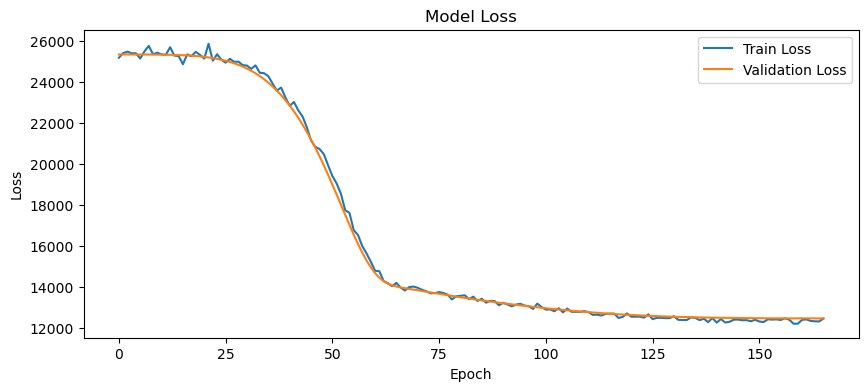

In [110]:
import torch
from torch.utils.data import TensorDataset

# 1. 实例化模型
model = SimpleNN(look_back=n_steps, n_features=X_train.shape[2]).to(device)

# 2. 准备 Dataset
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
val_dataset = TensorDataset(
    torch.tensor(X_validation, dtype=torch.float32),
    torch.tensor(y_validation, dtype=torch.float32),
)

# 3. 用 EarlyStopping 训练
history = train_with_early_stopping(
    model,
    train_data=train_dataset,
    val_data=val_dataset,
    epochs=1000,
    batch_size=128,
    patience=10,
    lr=0.001
)

# 4. 绘制损失曲线
plot_loss(history)

In [111]:
# 1. 把 numpy 或 array 转成 tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 2. 创建 TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 3. 调用评估函数
metrics = evaluate_regression(model, test_data=test_dataset)

MAE: 11074.0732
MSE: 138907232.0000
RMSE: 11785.8912
R2: -0.0818
MAPE: 106.5240%


In [112]:
import numpy as np
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_validation = np.array(X_validation, dtype=np.float32)
y_validation = np.array(y_validation, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [113]:
history = train_with_earlystopping(
    model,
    X_train, y_train,
    X_validation, y_validation,
    epochs=500,
    batch_size=64,
    patience=10
)

TypeError: train_with_earlystopping() got an unexpected keyword argument 'batch_size'

In [ ]:
plot_model_loss(history)

NameError: name 'plot_model_loss' is not defined

## Result analysis

Testing Length: 104


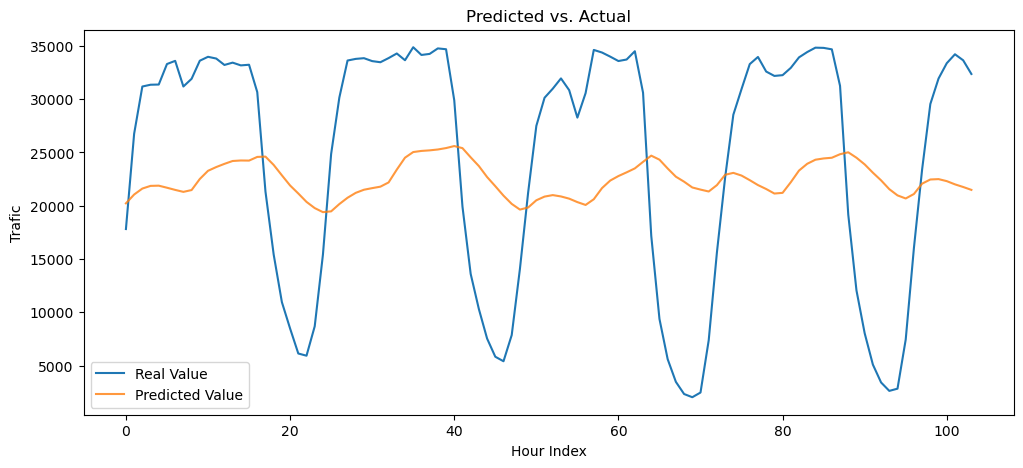

In [ ]:
plot_real_vs_predicted(
    model=model,
    X_test=X_test,
    y_test=y_test,
    start=0,
    end=104,
    figsize=(12, 5),
    title="Predicted vs. Actual",
    ylabel="Trafic",
    xlabel="Hour Index",
    alpha=0.8
)


In [117]:
print(f"Testing Length: {len(y_test)}")
start = 0
end = 104
predicted = model.predict(X_test).reshape(-1, 1)
plt.figure(figsize=(10, 4))
plt.plot(y_test[start : end ], label='Real Value')
plt.plot(predicted[start: end ], label='Predicted Value', alpha=0.7)
plt.title('Real vs Predicted Value')
plt.ylabel('Value')
plt.xlabel('Time Point')
plt.legend()
plt.show()

Testing Length: 104


AttributeError: 'SimpleNN' object has no attribute 'predict'

In [115]:
evaluate_regression(model, X_test, y_test)

TypeError: evaluate_regression() takes 2 positional arguments but 3 were given

## Save Results

In [116]:
import os
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# 定義一個函式，強制從 _1 開始依序編號檔名
def get_unique_filename(filename):
    """
    不論檔案是否存在，皆從 _1 開始附加到檔名上，
    若有同樣編號的檔案存在，則依序累加編號，直到找到尚不存在的檔名。
    """
    base, ext = os.path.splitext(filename)
    i = 1
    unique_filename = f"{base}_{i}{ext}"
    while os.path.exists(unique_filename):
        i += 1
        unique_filename = f"{base}_{i}{ext}"
    return unique_filename

# ------------------------
# 對測試集進行預測及計算指標
# ------------------------

# 進行測試集預測並轉換成一維陣列
predicted_test = model.predict(X_test).reshape(-1, 1)

# 計算各項回歸評估指標
mse = mean_squared_error(y_test, predicted_test)
mae = mean_absolute_error(y_test, predicted_test)
rmse = sqrt(mse)
r2 = r2_score(y_test, predicted_test)
mape = mean_absolute_percentage_error(y_test, predicted_test)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f'MAPE: {mape}')

# 將測試集真值與預測結果合併成 DataFrame
test_results = pd.DataFrame({
    'True': y_test.flatten(),
    'Predicted': predicted_test.flatten()
})

# 取得唯一檔名並儲存測試集結果成 CSV 檔案
test_csv_filename = get_unique_filename('test_predictions.csv')
test_results.to_csv(test_csv_filename, index=False)
print(f"測試集結果儲存到檔案: {test_csv_filename}")

# ------------------------
# 對訓練集進行預測並儲存結果
# ------------------------

# 預測訓練集資料
predicted_train = model.predict(X_train).reshape(-1, 1)

# 將訓練集真值與預測結果合併成 DataFrame
train_results = pd.DataFrame({
    'True': y_train.flatten(),
    'Predicted': predicted_train.flatten()
})

# 取得唯一檔名並儲存訓練集結果成 CSV 檔案
train_csv_filename = get_unique_filename('train_predictions.csv')
train_results.to_csv(train_csv_filename, index=False)
print(f"訓練集結果儲存到檔案: {train_csv_filename}")

AttributeError: 'SimpleNN' object has no attribute 'predict'

# Informer

In [21]:
# === Colab Cell 1: （可选）清理旧仓库并 clone 官方代码 ===
import os
import shutil

if os.path.isdir('/content/Informer2020'):
    print("检测到旧的 Informer2020 目录，正在移除...")
    shutil.rmtree('/content/Informer2020')

!git clone https://github.com/zhouhaoyi/Informer2020.git


Cloning into 'Informer2020'...
remote: Enumerating objects: 579, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 579 (delta 0), reused 0 (delta 0), pack-reused 577 (from 2)
Receiving objects: 100% (579/579), 6.49 MiB | 10.48 MiB/s, done.
Resolving deltas: 100% (331/331), done.


In [22]:
import sys
# 将仓库根目录加入路径
sys.path.append('/content/Informer2020')

# 从官方实现中导入 Informer
from models.model import Informer as InformerModel

Epoch 001/200 — Train 641158756.131516 — Val 641377479.710843
Epoch 002/200 — Train 638641652.349639 — Val 638508816.308434
Epoch 003/200 — Train 635399354.919006 — Val 634898115.932530
Epoch 004/200 — Train 631408923.663192 — Val 630617484.183133
Epoch 005/200 — Train 626826364.458701 — Val 625757605.937349
Epoch 006/200 — Train 621606841.020048 — Val 620219434.640964
Epoch 007/200 — Train 615719869.972735 — Val 614081739.334940
Epoch 008/200 — Train 609232210.476343 — Val 607356762.563855
Epoch 009/200 — Train 602190556.484362 — Val 600074536.559036
Epoch 010/200 — Train 594578547.271852 — Val 592245209.792771
Epoch 011/200 — Train 586399647.101844 — Val 583899708.838554
Epoch 012/200 — Train 577722674.861267 — Val 575053225.253012
Epoch 013/200 — Train 568622829.061748 — Val 565728420.857831
Epoch 014/200 — Train 558944696.686448 — Val 555951610.178313
Epoch 015/200 — Train 548849672.827586 — Val 545728116.626506
Epoch 016/200 — Train 538271659.983961 — Val 535081126.168675
Epoch 01

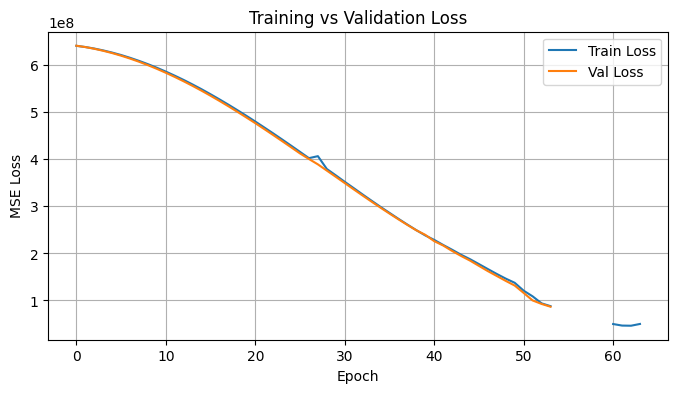

Test MSE: 96580790.139089


In [27]:
# === Colab Cell 1：导入依赖 ===
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt

from models.model import Informer as InformerModel  # 👈 forward 需 4 个输入：x_enc, x_mark_enc, x_dec, x_mark_dec

# 如果在 Notebook 里：
# %matplotlib inline


# === Colab Cell 2：准备数据 ===
# 假设你已在更早的 Cell 中定义好 NumPy 变量：
#   X_train, y_train, X_validation, y_validation, X_test, y_test
# 它们的形状分别为
#   X_*: (N, seq_len, input_dim)
#   y_*: (N,) 或者 (N,)

# 转 float32 并做成 Tensor
X_train      = torch.from_numpy(np.array(X_train,      dtype=np.float32))
y_train      = torch.from_numpy(np.array(y_train,      dtype=np.float32)).unsqueeze(-1)  # (N,1)
X_validation = torch.from_numpy(np.array(X_validation, dtype=np.float32))
y_validation = torch.from_numpy(np.array(y_validation, dtype=np.float32)).unsqueeze(-1)
X_test       = torch.from_numpy(np.array(X_test,       dtype=np.float32))
y_test       = torch.from_numpy(np.array(y_test,       dtype=np.float32)).unsqueeze(-1)

batch_size = 32
train_loader      = DataLoader(TensorDataset(X_train, y_train), batch_size, shuffle=True)
validation_loader = DataLoader(TensorDataset(X_validation, y_validation), batch_size)
test_loader       = DataLoader(TensorDataset(X_test, y_test), batch_size)


# === Colab Cell 3：定义模型 & 优化器 & 调度器 ===
input_dim  = X_train.shape[2]
output_dim = 1
seq_len    = 8
label_len  = seq_len
pred_len   = 1
d_feat     = 4

model = InformerModel(
    enc_in    = input_dim,
    dec_in    = input_dim,
    c_out     = output_dim,
    seq_len   = seq_len,
    label_len = label_len,
    out_len   = pred_len,
    factor    = 5,
    d_model   = 512,
    n_heads   = 8,
    e_layers  = 3,      # 增加 encoder 层数
    d_layers  = 2,      # 增加 decoder 层数
    d_ff      = 2048,
    dropout   = 0.1,
    attn      = 'prob',
    embed     = 'timeF',
    freq      = 'h'
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)


# === Colab Cell 4：训练 & 验证（含 EarlyStopping + Mixed Precision） ===
from torch.cuda.amp import autocast, GradScaler

num_epochs = 200
patience, wait = 20, 0
best_val_loss = float('inf')
scaler = GradScaler()

train_losses = []
val_losses   = []

eps = 1e-6

for epoch in range(1, num_epochs+1):
    # ——— 训练 ———
    model.train()
    total_train_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        # 全零时间特征（如需可替换为真实 time_features）
        x_mark_enc = torch.zeros(Xb.size(0), seq_len, d_feat, device=device)
        dec_in = torch.cat([
            Xb[:, -label_len:, :],
            torch.zeros(Xb.size(0), pred_len, input_dim, device=device)
        ], dim=1)
        x_mark_dec = torch.zeros(Xb.size(0), label_len+pred_len, d_feat, device=device)

        optimizer.zero_grad()
        with autocast():
            pred = model(Xb, x_mark_enc, dec_in, x_mark_dec).squeeze(-1)
            loss = criterion(pred, yb.squeeze(-1))
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item() * Xb.size(0)

    avg_train = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train)

    # ——— 验证 ———
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in validation_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            x_mark_enc = torch.zeros(Xb.size(0), seq_len, d_feat, device=device)
            dec_in = torch.cat([
                Xb[:, -label_len:, :],
                torch.zeros(Xb.size(0), pred_len, input_dim, device=device)
            ], dim=1)
            x_mark_dec = torch.zeros(Xb.size(0), label_len+pred_len, d_feat, device=device)

            pred = model(Xb, x_mark_enc, dec_in, x_mark_dec).squeeze(-1)
            total_val_loss += criterion(pred, yb.squeeze(-1)).item() * Xb.size(0)

    avg_val = total_val_loss / len(validation_loader.dataset)
    val_losses.append(avg_val)

    # ——— 调度 & EarlyStopping ———
    scheduler.step(avg_val)
    if avg_val + 1e-4 < best_val_loss:
        best_val_loss = avg_val
        wait = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f"EarlyStopping @ epoch {epoch}")
            break

    print(f"Epoch {epoch:03d}/{num_epochs} — Train {avg_train:.6f} — Val {avg_val:.6f}")


# === Colab Cell 5：画训练 & 验证 Loss 曲线 ===
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# === Colab Cell 6：测试集评估 & 预测 ===
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
total_test_loss = 0.0
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        x_mark_enc = torch.zeros(Xb.size(0), seq_len, d_feat, device=device)
        dec_in = torch.cat([
            Xb[:, -label_len:, :],
            torch.zeros(Xb.size(0), pred_len, input_dim, device=device)
        ], dim=1)
        x_mark_dec = torch.zeros(Xb.size(0), label_len+pred_len, d_feat, device=device)

        pred = model(Xb, x_mark_enc, dec_in, x_mark_dec).squeeze(-1)
        total_test_loss += criterion(pred, yb.squeeze(-1)).item() * Xb.size(0)

avg_test = total_test_loss / len(test_loader.dataset)
print(f"Test MSE: {avg_test:.6f}")

## PLOT

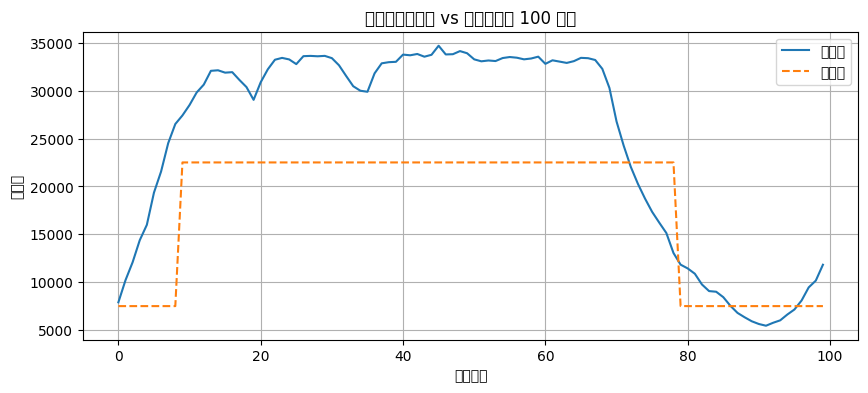

In [28]:
import matplotlib.pyplot as plt

# 1. 准备数据
# 将 y_test 转成 NumPy
y_true = y_test.cpu().numpy().squeeze()   # shape [N,]

# y_pred 已是 numpy，shape [N, pred_len]
# 如果 pred_len=1，就再 squeeze 成 [N,]
y_pred_1 = y_pred.squeeze()               # shape [N,]

# 2. 选择要画的点数
n_plot = min(100, len(y_true))  # 最多画 100 个点

# 3. 绘图
plt.figure(figsize=(10,4))
plt.plot(y_true[:n_plot], label='真實值')
plt.plot(y_pred_1[:n_plot], label='預測值', linestyle='--')
plt.xlabel('样本序号')
plt.ylabel('目标值')
plt.title('测试集：真實值 vs 預測值（前 {} 点）'.format(n_plot))
plt.legend()
plt.grid(True)
plt.show()

## ERROR

In [29]:
import torch

eps = 1e-6  # 防止除 0

# === Cell 6（或 Cell 5 中的验证段）替换成下面这段 ===
model.eval()
total_mse, total_mae, total_mape = 0.0, 0.0, 0.0
n_samples = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:  # 或 validation_loader
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # 构造 encoder/decoder 输入
        x_mark_enc = torch.zeros(X_batch.size(0), seq_len, d_feat, device=device)
        dec_in = torch.cat([
            X_batch[:, -label_len:, :],
            torch.zeros(X_batch.size(0), pred_len, input_dim, device=device)
        ], dim=1)
        x_mark_dec = torch.zeros(X_batch.size(0), label_len + pred_len, d_feat, device=device)

        # 前向
        pred = model(X_batch, x_mark_enc, dec_in, x_mark_dec).squeeze(-1)  # [B,]
        y_true = y_batch.squeeze(-1)                                     # [B,]

        # 各项指标
        mse   = torch.mean((pred - y_true) ** 2)
        mae   = torch.mean(torch.abs(pred - y_true))
        rmse  = torch.sqrt(mse)
        mape  = torch.mean(torch.abs((pred - y_true) / (y_true + eps))) * 100.0

        # 累加（按 batch 大小加权）
        bs = X_batch.size(0)
        total_mse  += mse.item()  * bs
        total_mae  += mae.item()  * bs
        total_mape += mape.item() * bs
        n_samples  += bs

# 计算全量平均
avg_mse  = total_mse  / n_samples
avg_rmse = avg_mse ** 0.5
avg_mae  = total_mae  / n_samples
avg_mape = total_mape / n_samples

print(f"Test MSE:  {avg_mse:.6f}")
print(f"Test RMSE: {avg_rmse:.6f}")
print(f"Test MAE:  {avg_mae:.6f}")
print(f"Test MAPE: {avg_mape:.2f}%")

Test MSE:  96580790.139089
Test RMSE: 9827.552602
Test MAE:  8866.915997
Test MAPE: 48.32%
